<div style="background-color:royalblue">
<img src="https://d3njjcbhbojbot.cloudfront.net/web/bundles/userModal/images/coursera-logo.svg">
</div>    

# <b style="color:#3b5998">www-coursera-downloader </b>

- this release: 20160628
- features: 
  - quiz downloader
  - html reading downloader
  - video downloader
  - creation of m3u playlist
  - added  <b style="color:#3b5998">colorful</b> heading and images
  - added section `download another course?`

(c) Jansen Simanullang, 2016-2018.

## <b style="color:#3b5998">A. Requirements</b>

### <b style="color:#3b5998">(1) Install Mozilla Geckodriver</b>
<img src="https://avatars2.githubusercontent.com/u/131524?s=200&v=4" width="75" height="75" alt="@mozilla" align="center"><br>
<li>Install [Mozilla Geckodriver](https://github.com/mozilla/geckodriver/releases/)
</li>

#### <b style="color:royalblue">Check Geckodriver version</b>

In [1]:
!echo Checking geckodriver version...
!geckodriver --version

Checking geckodriver version...
geckodriver 0.20.1

The source code of this program is available from
testing/geckodriver in https://hg.mozilla.org/mozilla-central.

This program is subject to the terms of the Mozilla Public License 2.0.
You can obtain a copy of the license at https://mozilla.org/MPL/2.0/.


### <b style="color:#3b5998">(2) Install Some Python Packages</b>
<img src="https://pypi.org/static/images/logo-small.6eef541e.svg">

In [2]:
!pip install -q bs4 jupyter_contrib_nbextensions mutagen pillow requests splinter
!jupyter nbextension enable python-markdown/main

Enabling notebook extension python-markdown/main...
      - Validating: OK


In [92]:
from splinter import Browser
import base64, getpass, json, os, re, requests, sys, time
from bs4 import BeautifulSoup
from mutagen.mp4 import MP4

## <b style="color:#3b5998">B. Definitions</b>

### <b style="color:royalblue">B. 1 Some constants</b>

In [93]:
# LOADING TIME
# WARNING: this will impact your user experience!
# adjust loading time according to your network speed!
# loading time in seconds

loading_time = 5

# HOMEPAGE
homepage='https://www.coursera.org'

# VIDEO RESOLUTION
# available resolution:
# 'hi', 'low' or 'med'
# choose according to your preference
resolution = {'low':'360','med':'540','hi':'720'}
chosen_res = 'hi'

# INITIAL DIRECTORY
initial_dirname = os.getcwd()

###  <b style="color:royalblue">B.2 Helper Functions</b>

<img src="https://www.3di.co.uk/wp-content/uploads/2016/06/Define.png" height="150" width="250">

In [207]:
def safe_text(str_text):
    erasable = [':','/']
    for e in erasable:   
        str_text = str_text.replace(e, ' ')  
    while '  ' in str_text:
        str_text = str_text.replace('  ',' ')
    return str_text

def create_download_dir(dirname):
    
    dirname = safe_text(dirname)
    
    try:
        os.mkdir(dirname)
    except:
        pass
    
    os.chdir(dirname)
    print(os.getcwd())

# SCREENSHOT
def screenshot():
    browser.driver.save_screenshot('screenshot.png')
    from PIL import Image
    return Image.open('screenshot.png')

# cjson helper functions

def encode_cjson(text):
    return base64.b64encode(bytes(str(text), "utf-8"))

def save_cjson(text):
    text = encode_cjson(text)
    with open('coursera.json','wb+') as f:
        f.write(bytes(str(text),"utf-8"))
    f.close()

def read_cjson():
    
    if os.path.isfile('coursera.json'):
        with open('coursera.json','rb') as f:
            a = f.read()
        f.close()
    else:
        print('credential file not found')
    return str(a).split("'")[1]

def decode_cjson(text):
    return str(base64.b64decode(text)).split("'")[1]

def get_cjson():

    text = read_cjson()
    
    uid = json.loads(decode_cjson(text))
    return uid

def remove_cjson():
    
    if os.path.isfile('coursera.json'):
        os.remove('coursera.json')

def get_credential():

    if os.path.isfile('coursera.json'):
        username = get_cjson()['user']
        password = get_cjson()['password']
    else:
        username = input('User Name:')
        password = getpass.getpass('Password:')
        text = '{"user":"'+username+'", "password":"'+password+'"}'
        save_cjson(text)
        
    return username, password

def remove_credential():
    remove_cjson()
    print('credential removed...')
    return

def reset_credential():
    remove_cjson()
    username, password = get_credential()
    return username, password

# vtt file conversion

def read_text_file(file_name):
    f = open(file_name, "r")
    print("\nvtt file being converted to srt: " + file_name)  
    return f.read()

def file_create(file_name, str_data):
    try:  
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    except IOError:        
        file_name = file_name.split(os.sep)[-1]
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    print("file created: " + file_name)
    
def convert_content(file_contents):
    replacement = re.sub(r'([\d]+)\.([\d]+)', r'\1,\2', file_contents)
    replacement = re.sub(r'WEBVTT\n\n', '', replacement)
    replacement = re.sub(r'^\d+\n', '', replacement)
    replacement = re.sub(r'\n\d+\n', '\n', replacement)
    return replacement

def vtt_to_srt(file_name):
    
    file_contents = read_text_file(file_name)
    str_data = ""
    str_data = str_data + convert_content(file_contents)  
    file_name = file_name.replace(".vtt",".srt")
    print(file_name)
    file_create(file_name, str_data)
    
# 
    
def get_mp4_url(lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        print('video playing will be paused in ' + str(loading_time) + ' seconds...')
        time.sleep(loading_time)
    try:
        browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
    except:
        time.sleep(loading_time)
        try:
            browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
        except:
            pass
        pass
    mp4 = browser.find_by_tag('video').find_by_tag('source')['src']
    mp4 = mp4.replace('360p/',resolution[chosen_res]+'p/')
    return mp4

def get_vtt_url(lesson_url):
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
    element = browser.find_by_css('li.rc-SubtitleDownloadItem.resource-list-item')
    vtt = BeautifulSoup(element.html, 'lxml').findAll('a')[0]['href']
    vtt = homepage + vtt
    return vtt

In [208]:
def vtt_downloader(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)    
    file_name = base_filename + '.vtt'
    file_exists = os.path.isfile(file_name)

    if file_exists:
        print('subtitle already downloaded.')
    else:
        vtt = get_vtt_url(lesson_url)
        r = requests.get(vtt)
        f = open(file_name, 'w')
        f.write(r.text)
        f.close()
    vtt_to_srt(file_name)
        
def mp4_downloader(lesson_id, lesson_title, lesson_url):
    
    mp4 = get_mp4_url(lesson_url)
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.mp4'

    downloaded_size = 0
    buffer_size = 1024

    print('requesting to download...')
    r = requests.get(mp4)
    content_length = r.headers['Content-Length']
    download_size = int(content_length)
    file_exists = os.path.isfile(file_name)
    
    if file_exists:
        
        if os.path.getsize(file_name) == download_size:
            print('mp4 already downloaded.')
            
    elif not file_exists:
        
        if r.status_code == 200:
            f = open(file_name, 'wb')
            for buffer in r.iter_content(buffer_size):
                f.write(buffer)
                downloaded_size += buffer_size
                status='\rdownloading...' + file_name + '>>> '
                status = status +str("{:.2f}".format(downloaded_size * 100. /download_size))+'%'
                sys.stdout.write(status)
                sys.stdout.flush()
            f.close()
        else:
            print('please check your connection..')

In [294]:
def reformat_html(html, page_title):
    
    # reading
    html = html.replace('<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div>',
                  '<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div> <h2 class="flex-1 align-self-center headline-4-text">'+page_title+'</h2>')

    html = html.replace('<div class="Box_120drhm-o_O-endJustify_b0g9ud-o_O-displayflex_poyjc" style="margin: 60px -60px -60px; border-top: 1px solid rgb(221, 221, 221); padding: 15px;"><div class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div></div></div>',
                        '')
    
    return html    
    
def reformat_html_quiz(html, page_title):    
    # quiz
    html = html.replace('<div class="header-back-arrow"><button class="back nostyle" role="button" tabindex="0"><i class="cif-back headline-2-text"></i><span class="screenreader-only">Back</span></button></div>',
                        '')
    html = html.replace('<div data-rc="ItemFeedback" class="c-quiz-item-feedback"><div data-reactroot="" class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div>',
                        '')
    
    return html

def write_html(base_filename, html):
    
    html = reformat_html(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def write_html_quiz(base_filename, html):
    
    html = reformat_html_quiz(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def quiz_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    try:
        buttons = browser.find_by_css('button')
        for button in buttons:
            if(button.text) == 'Continue':
                print(button.text)
                button.click()    
    except:
        pass
    
    try:
        time.sleep(loading_time)
        buttons = browser.find_by_css('button')
        for button in buttons:
            if(button.text) == 'Start' or button.text == 'Resume':
                print(button.text)
                button.click()
                break
        try:
            time.sleep(loading_time)
            html = browser.find_by_css('div.rc-FullscreenLayoutHandler').html
            print('got quiz item')
            base_filename = lesson_id +'-'+ safe_text(lesson_title)
            write_html_quiz(base_filename, html)
        except:
            print('no quiz content scraped.')
            pass
    except:
        print('something wrong...')
        html ='no quiz content scraped.'
        pass
    

    
def html_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    try:
        html = browser.find_by_css('div.item-page-content').html
        print('got reading item')
    except:
        html ='no content scraped.'
        pass
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    write_html(base_filename, html)
    
    return

def check_html_reading(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('html already downloaded.')
    else:
        html_downloader(lesson_id, lesson_title, lesson_url)
        

def check_mp4(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.mp4'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('mp4 already downloaded.')
    else:
        mp4_downloader(lesson_id, lesson_title, lesson_url)
        
        
def check_vtt(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.vtt'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('vtt already downloaded.')
    else:
        vtt_downloader(lesson_id, lesson_title, lesson_url)
        

def check_quiz(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('quiz already downloaded.')
    else:
        quiz_downloader(lesson_id, lesson_title, lesson_url)
        
### CREATE m3u PLAYLIST FILE
def create_m3u_playlist(course_title):
    
    seq = 0
    m3u_text = '#EXTM3U'+'\n'
    for root, dirs, files in os.walk(os.getcwd(), topdown=False):
        for name in sorted(files):
            if 'mp4' in name:
                seq += 1
                #mp4 = os.path.join(root, name)
                mp4 = (name)
                m3u_text += ('#EXTINF:'+str(int((MP4(mp4).info.length)))+','+ name) + '\n'
                m3u_text += (mp4) + '\n'
    playlist_base_name = safe_text(course_title).replace(' ','-')
    playlist_name = '000-'+playlist_base_name + '.m3u'
    f = open(playlist_name, 'w')
    f.write(m3u_text)
    f.close()
    print('playlist file created: '+playlist_name)

##  <b style="color:#3b5998">C. Coursera</b>

###  <b style="color:royalblue">(1) Login Page</b>


In [114]:
browser = Browser('firefox', headless = True)

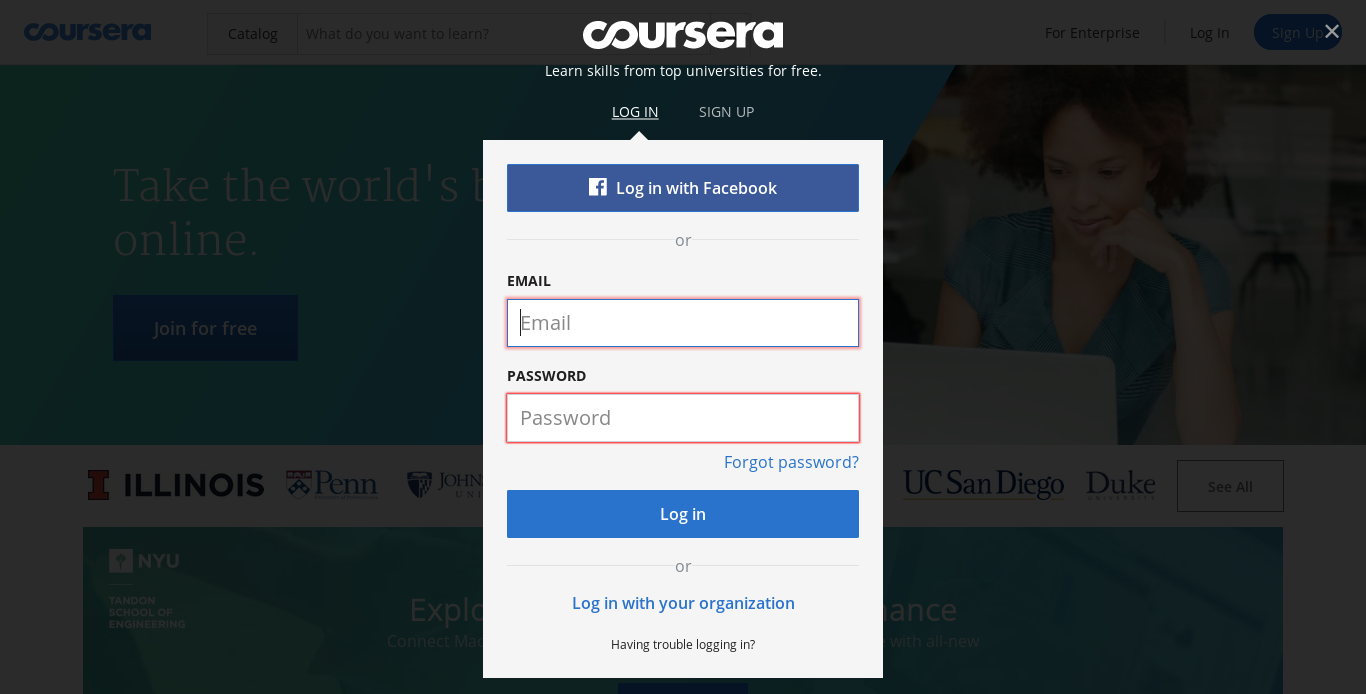

In [115]:
browser.visit('https://www.coursera.org/?authMode=login')
screenshot()

###  <b style="color:royalblue">Insert Login Credential</b>

In [116]:
#reset_credential() #uncomment to reset 
username, password = get_credential()

In [117]:
browser.visit('https://www.coursera.org/courses?authMode=login')

In [118]:
browser.fill('email', username)
browser.fill('password', password)

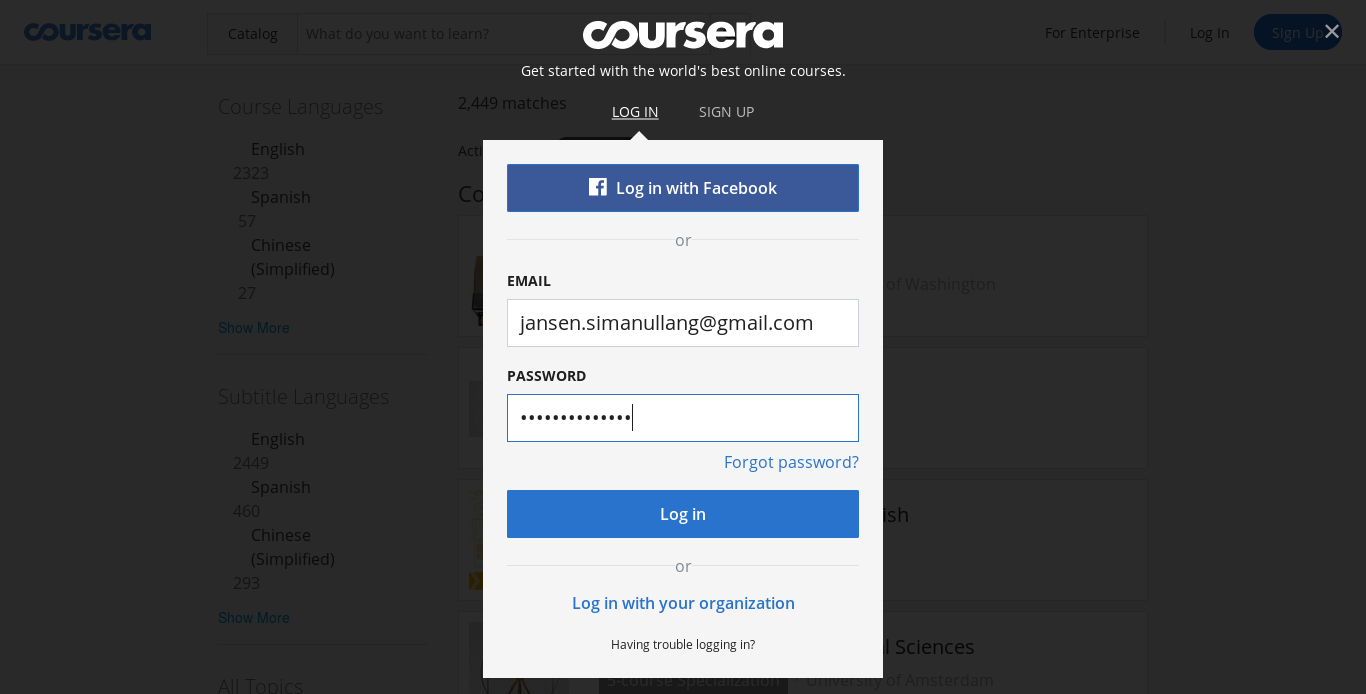

In [119]:
screenshot()

In [120]:
buttons = browser.find_by_tag('button')
for button in buttons:
    if (button.text == 'Log in'):
        button.click()
        break

###  <a name="last-active-courses"><b style="color:royalblue">LAST ACTIVE COURSES</b></a>

In [297]:
browser.visit(homepage)
section = browser.find_by_tag('section')
titles = []

for s in section:
    title = s.find_by_tag('h4').text
    titles.append(title)

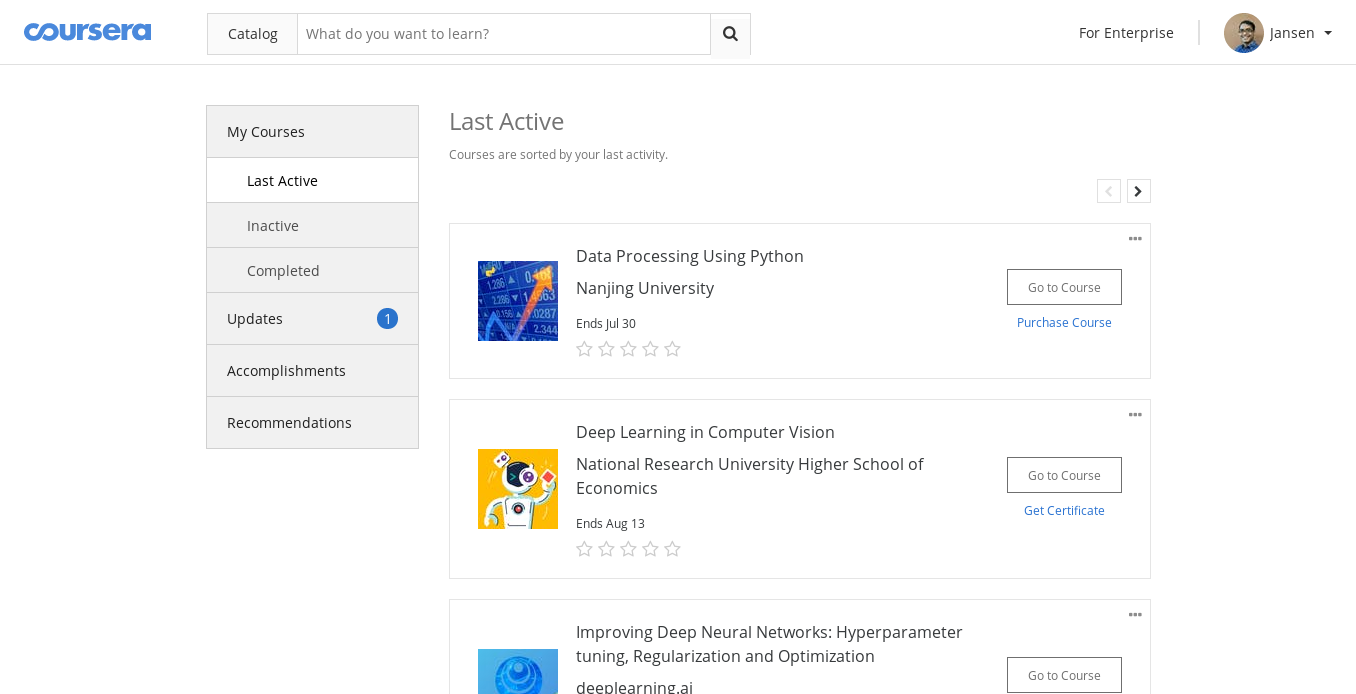

In [298]:
screenshot()

###  <b style="color:royalblue">PICK ONE OF THE COURSES</b>
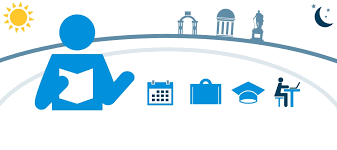

There are {{len(titles)}} courses visible in this section you can pick to download.

In [300]:
for i, title in enumerate(titles):
    print(i+1, title)
try:
    chosen_course = int(input('Choose a course number from [1] to ['+ str(len(titles))+']:\n'))
except:
    chosen_course = 1
course_title = titles[chosen_course-1]
print('>> You choose:\n'+course_title)

1 Data Processing Using Python
2 Deep Learning in Computer Vision
3 Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization
4 Sequence Models
5 Structuring Machine Learning Projects
6 Addressing Large Hadron Collider Challenges by Machine Learning
7 Convolutional Neural Networks
8 Neural Networks and Deep Learning
9 Machine Learning for Data Analysis
10 Regression Modeling in Practice
11 Exploratory Data Analysis
12 Exploratory Data Analysis
13 Reproducible Research
Choose a course number from [1] to [13]:
2
>> You choose:
Deep Learning in Computer Vision


 ### {{ titles[chosen_course-1] }}

In [301]:
section[chosen_course-1].click()
create_download_dir(course_title)

/home/bri/Development/my-github/www-coursera-downloader/Deep Learning in Computer Vision


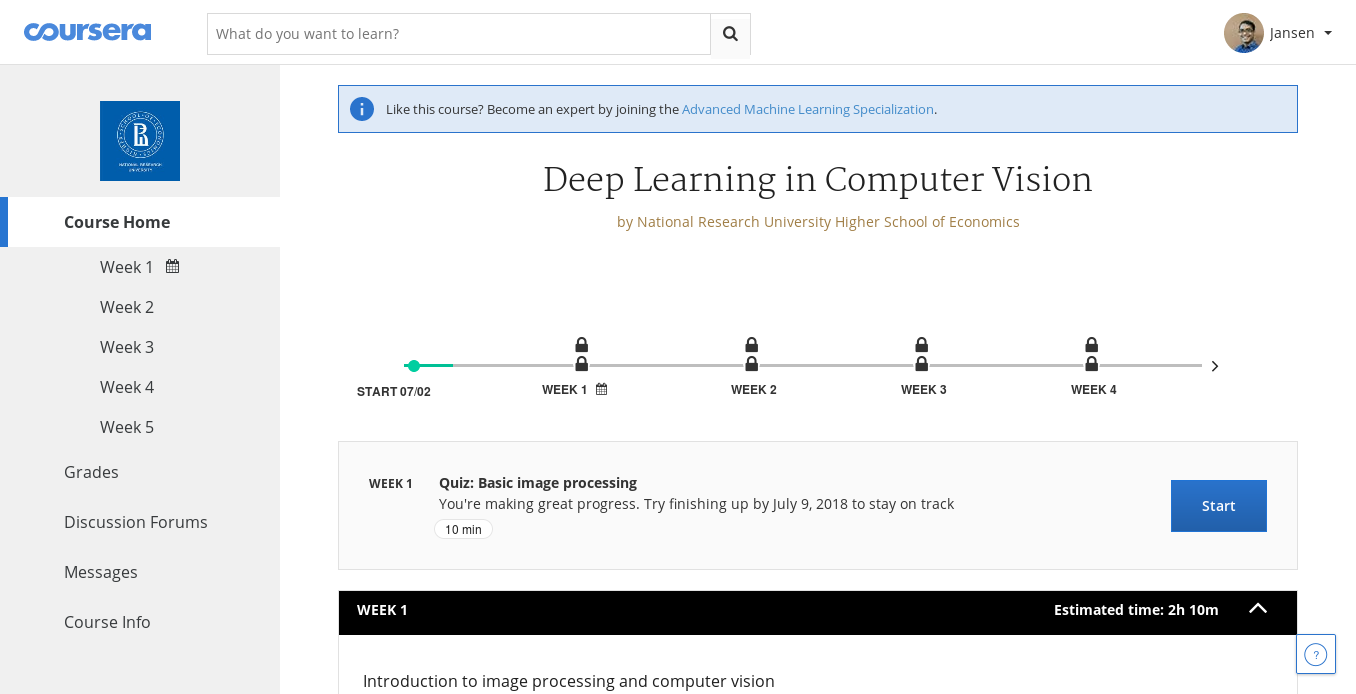

In [302]:
screenshot()

In [303]:
lecture_homepage = browser.driver.current_url

####  <b style="color:#3b5998">Enumerate Weeks</b>
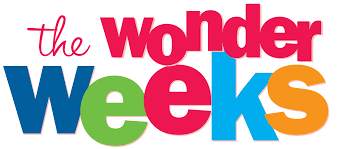

In [304]:
week = browser.find_by_css('div.rc-WeekCollectionNavigationItem > div')
anchors = BeautifulSoup(week.html, 'lxml').findAll('a', attrs={})
weeks = []
for a in anchors:
    weeks.append(a['href'])

weeks, len(weeks)

(['/learn/deep-learning-in-computer-vision/home/week/1',
  '/learn/deep-learning-in-computer-vision/home/week/2',
  '/learn/deep-learning-in-computer-vision/home/week/3',
  '/learn/deep-learning-in-computer-vision/home/week/4',
  '/learn/deep-learning-in-computer-vision/home/week/5'],
 5)

####  <b style="color:#3b5998">Enumerate Module Lessons</b>
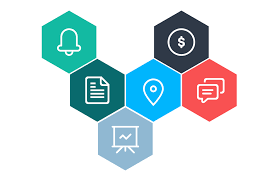

In [305]:
lessons_i = []
lessons_t = []
lessons_u = []
    
for w in range(len(weeks)):
    
    print('Collecting lessons title and urls...\n')    
    browser.visit(homepage + weeks[w])
    time.sleep(loading_time)
    w = w+1
    
    print('\nCollecting titles and urls from week: ' + str(w))
    time.sleep(loading_time)
    module_lessons = browser.find_by_css('div.rc-ModuleLessons')
    print()
    print('Week '+str(w)+' titles:')
    seq = 0
    for i, module_lesson in enumerate(module_lessons):

        lessons_title = module_lesson.find_by_tag('h5')

        for j, l in enumerate(lessons_title):
            seq  += 1
            lesson_id = str(w*100+seq).zfill(3)
            title = l.text.replace('\n',' ')
            print(lesson_id, title)
            title = safe_text(title)
            lessons_t.append(title)
            lessons_i.append(lesson_id)
    
    print()
    print('Week '+str(w)+' links:')    
    seq = 0

    for i, module_lesson in enumerate(module_lessons):

        lessons_url = module_lesson.find_by_tag('ul')
    
        for j, e in enumerate(lessons_url):
            anchors = BeautifulSoup(e.html, 'lxml').findAll('a')
            for k, a in enumerate(anchors):
                seq += 1
                lesson_id = str(w*100+seq).zfill(3)
                lesson_url = a['href']
                print(lesson_id, lesson_url)
                lessons_u.append(lesson_url)
           
    print()
    print('There are '+str(len(lessons_u)) + ' lesson titles available to check.')




Week 1 titles:
101 Lecture Short introduction to computer vision
102 Lecture Digital images
103 Lecture Structure of human eye and vision
104 Lecture Color models
105 Lecture Image processing goals and tasks
106 Lecture Contrast and brightness correction
107 Lecture Image convolution
108 Lecture Edge detection
109 Quiz: Basic image processing
110 Peer-graded Assignment: Image Alignment Notebook
111 Review Your Peers: Image Alignment Notebook

Week 1 links:
101 /learn/deep-learning-in-computer-vision/lecture/vOe4c/short-introduction-to-computer-vision
102 /learn/deep-learning-in-computer-vision/lecture/vcv1b/digital-images
103 /learn/deep-learning-in-computer-vision/lecture/jLskl/structure-of-human-eye-and-vision
104 /learn/deep-learning-in-computer-vision/lecture/Y8Wzn/color-models
105 /learn/deep-learning-in-computer-vision/lecture/k8aVl/image-processing-goals-and-tasks
106 /learn/deep-learning-in-computer-vision/lecture/JTX5e/contrast-and-brightness-correction
107 /learn/deep-lear

508 Quiz: Image segmentation and synthesis
509 Peer-graded Assignment: GAN notebook
510 Review Your Peers: GAN notebook

Week 5 links:
501 /learn/deep-learning-in-computer-vision/lecture/o5e7h/image-segmentation
502 /learn/deep-learning-in-computer-vision/lecture/Vv8Nr/oversegmentation
503 /learn/deep-learning-in-computer-vision/lecture/IQmOs/deep-learning-models-for-image-segmentation
504 /learn/deep-learning-in-computer-vision/lecture/k8jr8/human-pose-estimation-as-image-segmentation
505 /learn/deep-learning-in-computer-vision/lecture/PwXMb/style-transfer
506 /learn/deep-learning-in-computer-vision/lecture/VtrQf/generative-adversarial-networks
507 /learn/deep-learning-in-computer-vision/lecture/LrcEe/image-transformation-with-neural-networks
508 /learn/deep-learning-in-computer-vision/exam/E9UBb/image-segmentation-and-synthesis
509 /learn/deep-learning-in-computer-vision/peer/9h2K8/gan-notebook
510 /learn/deep-learning-in-computer-vision/peer/9h2K8/gan-notebook/give-feedback

There a

### Download Lecture Videos and Readings
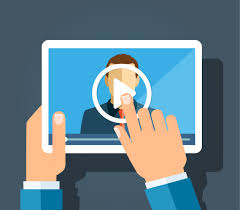

See the progress of downloading lecture videos, readings and quizzes.

In [306]:
os.chdir(initial_dirname)
os.chdir(safe_text(course_title))
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    print(a,b)
    first_word = b.split(' ')[0]
    
    if 'Lecture' in first_word:
        check_mp4(a,b,c)
        vtt_downloader(a,b,c)
        print()
        
    elif 'Reading' in first_word:
        check_html_reading(a, b, c)
        print()
        
    elif ('Quiz' in first_word) or ('Practice Quiz' in b):
        check_quiz(a, b, c)
        print()
    
    else:
        print('no resource to download.')
        
    print()
print('Resources downloaded to:\n'+os.getcwd())
os.chdir(initial_dirname)

101 Lecture Short introduction to computer vision
video playing will be paused in 5 seconds...
requesting to download...
downloading...101-Lecture Short introduction to computer vision.mp4>>> 100.01%
vtt file being converted to srt: 101-Lecture Short introduction to computer vision.vtt
101-Lecture Short introduction to computer vision.srt
file created: 101-Lecture Short introduction to computer vision.srt


102 Lecture Digital images
video playing will be paused in 5 seconds...
requesting to download...
downloading...102-Lecture Digital images.mp4>>> 100.00%
vtt file being converted to srt: 102-Lecture Digital images.vtt
102-Lecture Digital images.srt
file created: 102-Lecture Digital images.srt


103 Lecture Structure of human eye and vision
video playing will be paused in 5 seconds...
requesting to download...
downloading...103-Lecture Structure of human eye and vision.mp4>>> 100.01%
vtt file being converted to srt: 103-Lecture Structure of human eye and vision.vtt
103-Lecture Struct

downloading...301-Lecture Object detection problem.mp4>>> 100.01%
vtt file being converted to srt: 301-Lecture Object detection problem.vtt
301-Lecture Object detection problem.srt
file created: 301-Lecture Object detection problem.srt


302 Lecture Sliding windows
video playing will be paused in 5 seconds...
requesting to download...
downloading...302-Lecture Sliding windows.mp4>>> 100.01%
vtt file being converted to srt: 302-Lecture Sliding windows.vtt
302-Lecture Sliding windows.srt
file created: 302-Lecture Sliding windows.srt


303 Lecture HOG-based detector
video playing will be paused in 5 seconds...
requesting to download...
downloading...303-Lecture HOG-based detector.mp4>>> 100.02%
vtt file being converted to srt: 303-Lecture HOG-based detector.vtt
303-Lecture HOG-based detector.srt
file created: 303-Lecture HOG-based detector.srt


304 Lecture Detector training
video playing will be paused in 5 seconds...
requesting to download...
downloading...304-Lecture Detector training.

downloading...410-Lecture Action classification with convolutional neural networks.mp4>>> 100.00%
vtt file being converted to srt: 410-Lecture Action classification with convolutional neural networks.vtt
410-Lecture Action classification with convolutional neural networks.srt
file created: 410-Lecture Action classification with convolutional neural networks.srt


411 Lecture Action localization
video playing will be paused in 5 seconds...
requesting to download...
downloading...411-Lecture Action localization.mp4>>> 100.00%
vtt file being converted to srt: 411-Lecture Action localization.vtt
411-Lecture Action localization.srt
file created: 411-Lecture Action localization.srt


412 Quiz Video Analysis
Start
got quiz item


413 Peer-graded Assignment Face recognition notebook
no resource to download.

414 Review Your Peers Face recognition notebook
no resource to download.

501 Lecture Image segmentation
video playing will be paused in 5 seconds...
requesting to download...
downloading.

### The Playlist
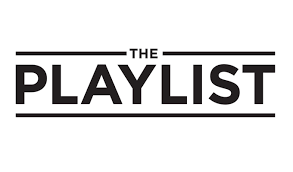

In [307]:
os.chdir(initial_dirname)
os.chdir(safe_text(course_title))
create_m3u_playlist(course_title)
os.chdir(initial_dirname)

playlist file created: 000-Deep-Learning-in-Computer-Vision.m3u


## <b style="color:#3b5998">D. Download Another Course?</b>

<a href="#last-active-courses">YES, Click Here</a> 

- then RUN the cells on LAST ACTIVE COURSES and continue to choose another course. 
- You may want to use your browser and open the corresponding course if the course is not seen the last active course list.

<a href="#close">NO, quit</a> 

- then RUN the cells with `browser.quit()` command.

##  <b style="color:#3b5998">E. Error Checking</b>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXcI6o52Fkp4wQV6fET12lDBZl1ZfqQpwdGP9265fpkVu3hc6k8Q">

###  <b style="color:#3b5998">(1) Screenshot Checking</b>

In case of an error, you may want to check the screenshot. Here is an example:

In [ ]:
screenshot()

###  <b style="color:#3b5998">(2) Manually Calling Downloader Functions</b>

In [ ]:
resource_idx = {}
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    resource_idx[a] = {'title':b, 'url':c}

# USER'S HELPER FUNCTIONS

def quiz_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    quiz_downloader(a, b, c)
    
def mp4_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    mp4_downloader(a, b, c) 
    
def html_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    html_downloader(a, b, c)
    
def vtt_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    vtt_downloader(a, b, c)

### <b style="color:green">Examples of Manually Calling Functions</b>
<img src="https://images-na.ssl-images-amazon.com/images/I/41IRMu3-78L.jpg">

**`mp4_download_by_id`**

Example usage:

```
mp4_download_by_id('103')
```
is equivalent to:

**`mp4_downloader`** 

```
mp4_downloader('103',
               'Lecture Meet your lecturers',
               '/learn/competitive-data-science/lecture/k0D2h/meet-your-lecturers')
```
`103` means week `1` sequence number `03` which is a lecture

**`quiz_download_by_id`**
```
quiz_download_by_id('406')
```
is equivalent to:

**`quiz_downloader`** 

```
quiz_downloader('406',
               'Practice Quiz Practice quiz', 
               '/learn/competitive-data-science/quiz/k7xTP/practice-quiz')
```
`406` means week `4` sequence number `06` which is a quiz

In [ ]:
# Example usage, edit and uncomment as you wish
#mp4_download_by_id('103')

## <a name="close"> <b style="color:#3b5998">F. Finally Close the Browser After Download</b></a>
<img src="https://media.tenor.com/images/33c7bbf779e792d8a25ba1e5b80d8c9f/tenor.gif">

In [113]:
browser.quit()
os.chdir(initial_dirname)
os.getcwd()

'/home/bri/Development/my-github/www-coursera-downloader'